In [1]:
import urllib.request
import bs4
import pandas as pd
import numpy as np
import pickle
import re


def create_dfs(url, filename):
    """ Create dataframes given url of tfrrs performance list
    """
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers = {'User-Agent':user_agent,} 
    request = urllib.request.Request(url,None,headers)
    response = urllib.request.urlopen(request)
    webpage = response.read()
    soup = bs4.BeautifulSoup(webpage, 'html.parser')
    panel_body = soup.findAll("div", {"class": "panel-body"})
    events = panel_body[0].find_all("div", class_="col-lg-12")
    events_dict = {}
    regex = re.compile(r'[\n\r\t]')
    for event in events:
        event_name = event.find("h3") .renderContents().decode('utf-8').strip()
        event_name = regex.sub("", event_name)
        table = event.find("table")
        df = pd.read_html(str(table))[0]
        events_dict[event_name] = df
    with open(filename, "wb") as fp:
        pickle.dump(events_dict, fp)
    print("Saved data parsed from " + url + " as " + filename + " in current file")
    return events_dict


def load_dfs(filename):
    """ Load previously creaetd dataframes
    """
    with open(filename, "rb") as fp:
        events_dict = pickle.load(fp)
    return events_dict
    
    

In [2]:
# Some helpful event title parsing functions...

def get_name_gender(event):
    """ Get name of event and gender of event
    """
    name, gender = event.split("(")
    return name.strip(), gender.strip(")")
    
    
def get_category(event):
    """ Get category of event
    """
    name, _ = get_name_gender(event)
    tag = ""
    sprint = ["60 Meters", "100 Meters", "200 Meters", "400 Meters"]
    middle_distance = ["800 Meters", "1500 Meters", "Mile"]
    distance = ["3000 Meters", "3000 Steeplechase", "5000 Meters", "10,000 Meters"]
    hurdle = ["60 Hurdles", "100 Hurdles", "110 Hurdles", "400 Hurdles"]
    relay = ["4 x 100 Relay", "4 x 400 Relay", "Distance Medley Relay"]
    jump = ["High Jump", "Long Jump", "Triple Jump", "Pole Vault"]
    throw = ["Shot Put", "Discus", "Javelin", "Hammer", "Weight Throw"]
    multi = ["Pentathlon", "Heptathlon", "Decathlon"]
    if name in sprint:
        tag = "sprint"
    elif name in middle_distance:
        tag = "middle_distance"
    elif name in distance:
        tag = "distance"
    elif name in hurdle:
        tag = "hurdle"
    elif name in relay:
        tag = "relay"
    elif name in jump:
        tag = "jump"
    elif name in throw:
        tag = "throw"
    elif name in multi:
        tag = "multi"
    return tag


def get_perf(event):
    """ Get type of performance of event
    """
    category = get_category(event)
    perf = ""
    time = ["sprint", "middle_distance", "distance", "hurdle", "relay"]
    mark = ["jump", "throw"]
    points = ["multi"]
    if category in time:
        perf = "TIME"
    elif category in mark:
        perf = "MARK"
    elif category in points:
        perf = "POINTS"
    return perf
        
        

In [3]:
import pandas as pd
from IPython.display import display
import numpy as np

class scoreboard:
    """ Create a scoreboard for a season
    Inputs::
    events_dict: Dictionary of dataframes, one for each event (from create_dfs or load_dfs)
    gender: Men or Women
    standards: Dictionary that maps event name to standard
    individual_limit: Maximum number of points a single athlete can score in a season
    event_limit: Maximum number of points a team can score in a single event in a season
    relay_worth: How many points a relay is worth
    
    Use::
    First, create scoreboard object
    sb = scoreboard(tables, gender, standards, individual_limit, event_limit, relay_worth)
    
    Update any parameters of scoreboard with any of the following functions, if you so choose:
    update_events_dict(events_dict)
    update_gender(gender)
    update_standards(standards)
    update_individual_limit(individual_limit)
    update_event_limit(event_limit)
    update_relay_worth(relay_worth)
    
    Check parameter values and return the current standards dictionary with get_standards()
    
    Finally, with all the current parameters, create a scoreboard dataframe and save it in current file
    df = sb.get_score_df()
    """
    
    def __init__(self, events_dict, gender, standards, individual_limit, event_limit, relay_worth):
        self.tables = events_dict
        self.gender = gender
        self.standards = standards
        self.individual_limit = individual_limit
        self.event_limit = event_limit
        self.relay_worth = relay_worth
        
        
    def get_standards(self, verbose):
        if verbose:
            print("Gender: " + self.gender)
            print("Individual Point Limit: " + str(self.individual_limit))
            print("Event Point Limit: " + str(self.event_limit))
            print("Relay Point Value: " + str(self.relay_worth))
            print("Standards: ")
            print(self.standards)
        return self.standards
        
        
    def update_events_dict(self, events_dict):
        self.events_dict = events_dict
        return True
    
    
    def update_gender(self, gender):
        self.gender = gender
        return True
    
    
    def update_standards(self, standards):
        self.standards = standards
        return True
    
    
    def update_individual_limit(self, individual_limit):
        self.individual_limit = inidividual_limit
        return True
    
    
    def update_event_limit(self, event_limit):
        self.event_limit = event_limit
        return True
    
    
    def update_relay_worth(self, relay_worth):
        self.relay_worth = relay_worth
        return True
        

    def __get_score_df(self):
        columns = ["Team", "Points", "Points_by_athlete", "Points_by_event"]
        score_df = pd.DataFrame(columns = columns)
        for event in self.tables:
            event_name, event_gender = get_name_gender(event)
            event_cat = get_category(event)
            event_perf = get_perf(event)
            if event_gender == self.gender:
                table = self.tables[event]
                for index in range(len(table)):
                    team = table.loc[index, "TEAM"]
                    if self.__is_copy(team):
                        continue
                    if event_cat != "relay":
                        athlete = table.loc[index, "ATHLETE"]
                    else:
                        athlete = table.loc[index, "ATHLETES"]
                    perf = table.loc[index, event_perf]
                    if (score_df["Team"] == team).any():
                        score_series = score_df.loc[score_df["Team"] == team].squeeze()
                        exists = True
                    else:
                        score_series = pd.Series({"Team":team, "Points":0, "Points_by_athlete":{}, "Points_by_event":{}})
                        exists = False
                    points = score_series["Points"]
                    points_by_athlete = score_series["Points_by_athlete"]
                    points_by_event = score_series["Points_by_event"]
                    if athlete in points_by_athlete:
                        tot_athlete_points = points_by_athlete[athlete]
                    else:
                        tot_athlete_points = 0
                    if event in points_by_event:
                        tot_event_points = points_by_event[event]
                    else:
                        tot_event_points = 0
                    if self.__gets_point(event, perf, tot_athlete_points, tot_event_points):
                        if event_cat == "relay":
                            points += self.relay_worth
                        else:
                            points += 1
                        if event_cat != 'relay':
                            points_by_athlete[athlete] = tot_athlete_points + 1
                        points_by_event[event] = tot_event_points + 1
                        new_score_series = pd.Series({"Team":team, "Points":points, "Points_by_athlete":points_by_athlete, "Points_by_event":points_by_event})
                        if exists:
                            score_df.drop(score_df[score_df['Team'] == team].index, inplace = True) 
                        score_df = score_df.append(new_score_series, ignore_index=True)
        score_df = score_df.sort_values(by = "Points", ascending=False)
        return score_df

    
    def __gets_point(self, event, perf, tot_athlete_points, tot_event_points):
        result = False
        if get_category(event) == 'relay':
            event_limit = 1
        else:
            event_limit = self.event_limit
        if tot_athlete_points < self.individual_limit:
            if tot_event_points < event_limit:
                if self.__meets_standard(event, perf):
                    result = True
        return result
    
    
    def __meets_standard(self, event, perf):
        meets = False
        standard = self.standards[event]
        perf = str(perf)
        perf = perf.strip("#@")
        if get_perf(event) == "TIME":
            perf = self.__get_seconds(perf)
            standard = self.__get_seconds(standard)
            if perf <= standard:
                meets = True
        elif get_perf(event) == "MARK":
            perf = float(perf[:-1])
            standard = float(standard[:-1])
            if perf >= standard:
                meets = True
        elif get_perf(event) == "POINTS":
            perf = float(perf)
            standard = float(standard)
            if perf >= standard:
                meets = True
        return meets
    
    
    def __get_seconds(self, my_str):
        if "(" in my_str:
            my_str, _ = my_str.split("(")
        if ":" in my_str:
            m, s = my_str.split(':')
            return int(m) * 60 + float(s)
        else:
            return float(my_str)
        
    
    def __is_copy(self, team):
        result = False
        exclude = ["(A)", "(B)", "(C)", "(D)", "(E)", "(F)", "(G)", "(H)", "(I)"]
        for e in exclude:
            if e in team:
                result = True
        return result
    
    
    def get_score_df(self):
        score_df = self.__get_score_df()
        score_df = score_df.reset_index(drop=True)
        print("Scoreboard of Top 32 teams: ")
        display(score_df.iloc[0:32])
        return score_df

In [4]:
# Function to easily create standards along with other useful random stuff

def create_standards_automatic(events_dict_list, solo_cap, relay_cap):
    """ Create standards based on average place finish for collection of years
    NOTE: Issues with Indoor expected, haven't programmed conversion between track types (prob never will)
    
    Input::
    events_dict_list: List of events_dict objects 
    solo_cap: For solo events, place corresponding to standard
    relay_cap: For relay events, place corresponding to relay
    
    You can always edit the standards after the fact - this will quickly generate a basic standards dictionary
    """
    solo_cap = solo_cap - 1
    relay_cap = relay_cap - 1
    standards = {}
    for event in events_dict_list[0]:
        event_perfs = []
        perf_type = get_perf(event)
        if get_category(event) == "relay":
            cap = relay_cap
        else:
            cap = solo_cap
        for event_dict in events_dict_list:
            perf = str(event_dict[event].loc[cap, perf_type])
            perf = perf.strip("#@")
            if perf_type == "TIME":
                perf = get_seconds(perf)
            elif perf_type == "MARK":
                perf = float(perf[:-1])
            elif perf_type == "POINTS":
                perf = float(perf)
            event_perfs.append(perf)
        value = sum(event_perfs)/len(event_perfs)
        if perf_type == "TIME":
            standard = get_time(value)
        elif perf_type == "MARK":
            standard = str(value) + "m"
        elif perf_type == "POINTS":
            standard = str(value)
        standards[event] = standard
    return standards
                
             
def get_seconds(my_str):
    if "(" in my_str:
        my_str, _ = my_str.split("(")
    if ":" in my_str:
        m, s = my_str.split(':')
        return int(m) * 60 + float(s)
    else:
        return float(my_str)

    
def get_time(seconds):
    seconds = seconds % (24 * 3600) 
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    if minutes > 0:
        return "%d:%05.2f" % (minutes, seconds) 
    else:
        seconds = round(seconds,2)
        return str(round(seconds, 2))

    
def save_sb(sb, filename):
    """ Save scoreboard object or scoreboard dataframe
    """
    with open(filename, "wb") as fp:
        pickle.dump(sb, fp)
    return True

    
def load_sb(filename):
    """ Load previously created scoreboard object or scoreboard dataframe
    """
    with open(filename, "rb") as fp:
        scoreboard = pickle.load(fp)
    return scoreboard
        


In [12]:
## Only run this block to create new data

# First, get tfrrs performance list url
url = "https://www.tfrrs.org/lists/2572.html?limit=%3C%3D200&event_type=all&year=&gender=x"


# Create Dictionary of Pandas Dataframes for each event
events_dict = create_dfs(url, "2019_d3_outdoor_raw")
#events_dict = load_dfs("2019_d3_outdoor")


# Create Standards
standards = create_standards_automatic([events_dict], 100, 45)


# Feed other desired parameters:
gender = "Men"
individual_limit = 4
event_limit = 7
relay_worth = 3


# Create scoreboard object:
sb = scoreboard(events_dict, gender, standards, individual_limit, event_limit, relay_worth)


# Check parameters of scoreboard object:
_ = sb.get_standards(True)


# Create scoreboard dataframe
df = sb.get_score_df()


# Save scoreboard object
save_sb(sb, "2019_d1_outdoor_scoreboard")

Saved data parsed from https://www.tfrrs.org/lists/2572.html?limit=%3C%3D200&event_type=all&year=&gender=x as 2019_d3_outdoor_raw in current file
Gender: Men
Individual Point Limit: 4
Event Point Limit: 7
Relay Point Value: 3
Standards: 
{'100 Meters (Men)': '10.89', '100 Meters (Women)': '12.46', '200 Meters (Men)': '22.01', '200 Meters (Women)': '25.64', '400 Meters (Men)': '49.33', '400 Meters (Women)': '58.58', '800 Meters (Men)': '1:54.98', '800 Meters (Women)': '2:17.60', '1500 Meters (Men)': '3:57.51', '1500 Meters (Women)': '4:44.35', '5000 Meters (Men)': '14:54.77', '5000 Meters (Women)': '17:53.01', '10,000 Meters (Men)': '31:44.94', '10,000 Meters (Women)': '38:34.34', '100 Hurdles (Women)': '15.24', '110 Hurdles (Men)': '15.3', '400 Hurdles (Men)': '55.83', '400 Hurdles (Women)': '1:05.87', '3000 Steeplechase (Men)': '9:38.09', '3000 Steeplechase (Women)': '11:42.88', '4 x 100 Relay (Men)': '41.69', '4 x 100 Relay (Women)': '48.35', '4 x 400 Relay (Men)': '3:17.64', '4 x 40

,Team,Points,Points_by_athlete,Points_by_event
0,Wis.-La Crosse,53,"{'Koenecke, Josh': 1, 'Holden, Seth': 2, 'DeBr...","{'100 Meters (Men)': 5, '200 Meters (Men)': 4,..."
1,North Central (Ill.),40,"{'Piron, Peyton': 1, 'Stanley, Michael': 1, 'C...","{'400 Meters (Men)': 3, '800 Meters (Men)': 2,..."
2,Washington U.,37,"{'Wintergalen, Eddie': 2, 'Wagner, John Harry'...","{'200 Meters (Men)': 2, '400 Meters (Men)': 4,..."
3,Wis.-Oshkosh,37,"{'Jung, Benny': 2, 'Ogbuli, Robert': 1, 'Richa...","{'100 Meters (Men)': 5, '200 Meters (Men)': 2,..."
4,Wis.-Eau Claire,36,"{'Munn, KJ': 2, 'Christnovich, Brandon': 1, 'H...","{'200 Meters (Men)': 1, '400 Meters (Men)': 3,..."
5,Rowan,32,"{'Pratt, Julian': 1, 'Murray, Dayquan': 2, 'Mu...","{'100 Meters (Men)': 2, '200 Meters (Men)': 2,..."
6,Claremont-Mudd-Scripps,32,"{'Bethurem, Corbin': 2, 'Cockburn, Jamie': 2, ...","{'100 Meters (Men)': 1, '200 Meters (Men)': 2,..."
7,St. Thomas (Minn.),30,"{'Douville, Eric': 2, 'Kozlowski, Carl': 1, 'W...","{'100 Meters (Men)': 1, '200 Meters (Men)': 1,..."
8,Pomona-Pitzer,30,"{'Tamkin, Daniel': 1, 'Marsano, Nick': 2, 'Pas...","{'200 Meters (Men)': 2, '400 Meters (Men)': 1,..."
9,Wis.-Platteville,29,"{'Burcham, Alec': 1, 'Lee, Zach': 3, 'Wallenka...","{'400 Meters (Men)': 1, '800 Meters (Men)': 2,..."


True

In [5]:
## For loading in previously created scoreboard

sb = load_sb("2018_d3_indoor_scoreboard")
#df = sb.get_score_df()

sb.get_standards(True)


Gender: Women
Individual Point Limit: 4
Event Point Limit: 7
Relay Point Value: 3
Standards: 
{'60 Meters (Men)': '7.05', '60 Meters (Women)': '7.97', '200 Meters (Men)': '22.28', '200 Meters (Women)': '25.92', '400 Meters (Men)': '49.83', '400 Meters (Women)': '59.29', '800 Meters (Men)': '1:55.45', '800 Meters (Women)': '2:18.69', 'Mile (Men)': '4:17.77', 'Mile (Women)': '5:08.33', '3000 Meters (Men)': '8:37.02', '3000 Meters (Women)': '10:19.88', '5000 Meters (Men)': '15:05.10', '5000 Meters (Women)': '18:13.53', '60 Hurdles (Men)': '8.56', '60 Hurdles (Women)': '9.35', '4 x 400 Relay (Men)': '3:19.35', '4 x 400 Relay (Women)': '3:59.00', 'Distance Medley Relay (Men)': '10:13.28', 'Distance Medley Relay (Women)': '12:20.31', 'High Jump (Men)': '1.93m', 'High Jump (Women)': '1.58m', 'Pole Vault (Men)': '4.4m', 'Pole Vault (Women)': '3.25m', 'Long Jump (Men)': '6.72m', 'Long Jump (Women)': '5.32m', 'Triple Jump (Men)': '13.53m', 'Triple Jump (Women)': '10.87m', 'Shot Put (Men)': '14.6

{'60 Meters (Men)': '7.05',
 '60 Meters (Women)': '7.97',
 '200 Meters (Men)': '22.28',
 '200 Meters (Women)': '25.92',
 '400 Meters (Men)': '49.83',
 '400 Meters (Women)': '59.29',
 '800 Meters (Men)': '1:55.45',
 '800 Meters (Women)': '2:18.69',
 'Mile (Men)': '4:17.77',
 'Mile (Women)': '5:08.33',
 '3000 Meters (Men)': '8:37.02',
 '3000 Meters (Women)': '10:19.88',
 '5000 Meters (Men)': '15:05.10',
 '5000 Meters (Women)': '18:13.53',
 '60 Hurdles (Men)': '8.56',
 '60 Hurdles (Women)': '9.35',
 '4 x 400 Relay (Men)': '3:19.35',
 '4 x 400 Relay (Women)': '3:59.00',
 'Distance Medley Relay (Men)': '10:13.28',
 'Distance Medley Relay (Women)': '12:20.31',
 'High Jump (Men)': '1.93m',
 'High Jump (Women)': '1.58m',
 'Pole Vault (Men)': '4.4m',
 'Pole Vault (Women)': '3.25m',
 'Long Jump (Men)': '6.72m',
 'Long Jump (Women)': '5.32m',
 'Triple Jump (Men)': '13.53m',
 'Triple Jump (Women)': '10.87m',
 'Shot Put (Men)': '14.65m',
 'Shot Put (Women)': '12.09m',
 'Weight Throw (Men)': '15.85m

In [197]:
# Some functions to analyze the data

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import json


def get_point_distribution(scoreboard_df, maxIndex):
    ax = scoreboard_df.iloc[0:maxIndex].plot.bar(y = "Points", figsize = (12,5))
    ax.set_xticklabels(labels = {})
    ax.set_ylabel("Points")
    ax.set_yticks(ticks = range(0,scoreboard_df.loc[0,"Points"],5))
    ax.set_title("Point Distribution of top " + str(maxIndex) + " teams")
    ax.get_legend().remove()

    
def get_event_distribution(scoreboard_df, team, relay_worth, show_plots):
    sprint = 0
    middle_distance = 0
    distance = 0
    hurdle = 0
    relay = 0
    jump = 0
    throw = 0
    multi = 0
    idx = scoreboard_df.loc[scoreboard_df["Team"] == team].index[0]
    points_by_event = scoreboard_df.loc[idx,"Points_by_event"]
    points_by_athlete = scoreboard_df.loc[idx, "Points_by_athlete"]
    for event in points_by_event:
        name, gender = get_name_gender(event)
        category = get_category(event)
        points = points_by_event[event]
        if category == "sprint":
            sprint += points
        elif category == "middle_distance":
            middle_distance += points
        elif category == "distance":
            distance += points
        elif category == "hurdle":
            hurdle += points
        elif category == "relay":
            relay += points * relay_worth
        elif category == "jump":
            jump += points
        elif category == "throw":
            throw += points
        elif category == "multi":
            multi += points
    bar_names = ["Sprints", "Middle Distance", "Long Distance", "Hurdles", "Relays", "Jumps", "Throws", "Multi"]
    bar_pos = [1,6,12,17,21,25,29,33]
    bar_vals = [sprint, middle_distance, distance, hurdle, relay, jump, throw, multi]
    if show_plots:
        plt.style.use('fivethirtyeight')
        plt.figure(figsize = (12,5))
        plt.bar(bar_pos, bar_vals, alpha = 1)
        plt.xticks(bar_pos, bar_names)
        plt.title("Point distribution by event category for " + team)
        plt.xlabel("Event Category")
        plt.ylabel("Points")
        plt.show()
        
        print("Full point breakdown: ")
        print(json.dumps(points_by_event, indent=1))
        print(json.dumps(points_by_athlete, indent=1, sort_keys=True))
        print("Total Points: " + str(scoreboard_df.loc[idx, "Points"]))
        print("Unique events scored in: " + str(len(points_by_event)))
        print("Unique athletes to score (not including on relay): " + str(len(points_by_athlete)))
        print("Most points scored in a single event: " + str(max(points_by_event.values())))
        most = max(points_by_athlete.values())
        percent = str(round(most*100/(scoreboard_df.loc[idx,"Points"]),2))
        print("Most points scored by a single athlete: " + str(most) + " ("+percent+"% of total points scored)")
        print("")
    return bar_vals


def cluster_teams_by_event_category(df, maxIndex, relay_worth):
    data = np.zeros([maxIndex, 8])
    team_names = []
    for team_id in range(maxIndex):
        team_data = df.iloc[team_id]
        team = team_data["Team"]
        team_names.append(team)
        bar_vals = get_event_distribution(df, team, relay_worth, False)
        data[team_id,:] = np.array(bar_vals)
    data_mean = data.mean(axis = 0)
    data_scaled = preprocessing.scale(data)
    
    model = KMeans()
    print("First finding the optimal number of clusters...")
    max_cluster = min(20, maxIndex)
    visualizer = kelbow_visualizer(model, data_scaled, k = (4,max_cluster), metric="silhouette", show=False, timings=False)
    n_clusters = visualizer.elbow_value_
    if n_clusters == None:
        n_clusters = max_cluster
    print("Optimal number of clusters: " + str(n_clusters))
    
    kmeans = KMeans(n_clusters=n_clusters).fit(data_scaled)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    closest, _ = pairwise_distances_argmin_min(centers, data_scaled)
    
    plt.style.use('fivethirtyeight')
    bar_names = ["Sprints", "Middle Distance", "Long Distance", "Hurdles", "Relays", "Jumps", "Throws", "Multi"]
    bar_pos = [1,6,12,17,21,25,29,33]
    bar_vals = data_mean
    plt.figure(figsize = (12,5))
    plt.bar(bar_pos, bar_vals, alpha = 1)
    plt.xticks(bar_pos, bar_names)
    plt.title("Average Points per Event Category")
    plt.xlabel("Event Category")
    plt.ylabel("Points")
    plt.show()
    
    for center in range(centers.shape[0]):
        bar_vals = centers[center,:]
        num_in = sum(labels == center)
        colors = ['b','b','b','b','b','b','b','b']
        for c in range(len(colors)):
            if bar_vals[c] < 0:
                colors[c] = 'r'
        tot = sum(bar_vals)
        plt.figure(figsize = (12,5))
        plt.bar(bar_pos, bar_vals, alpha = 1, color = colors)
        plt.xticks(bar_pos, bar_names)
        plt.title("Point distribution cluster center with " + str(num_in) + " members (" + str(round(tot,1)) + " total points)")
        plt.xlabel("Event Category")
        plt.ylabel("Points")
        plt.show()
        
        print("Best Example from Cluster: ")
        
        bv = data[closest[center],:]
        plt.figure(figsize = (12,5))
        plt.bar(bar_pos, bv, alpha = 1)
        plt.xticks(bar_pos, bar_names)
        plt.title("Point distribution cluster center for " + team_names[closest[center]] + " (" + str(sum(data[closest[center],:])) + " total points)")
        plt.xlabel("Event Category")
        plt.ylabel("Points")
        plt.show()
        print("")
        print("")
                
        
        
        

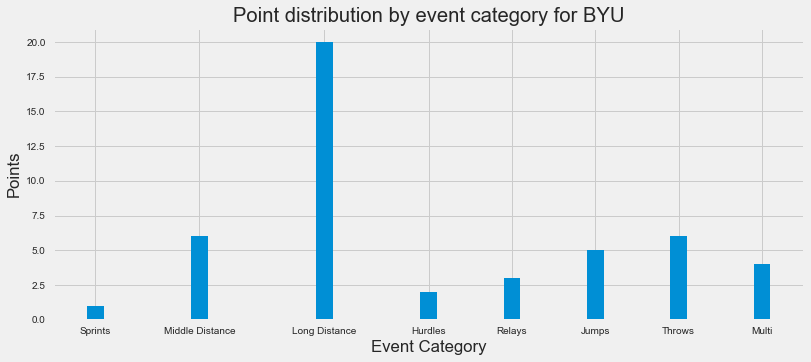

Full point breakdown: 
{
 "400 Meters (Men)": 1,
 "1500 Meters (Men)": 6,
 "5000 Meters (Men)": 7,
 "10,000 Meters (Men)": 7,
 "400 Hurdles (Men)": 2,
 "3000 Steeplechase (Men)": 6,
 "4 x 400 Relay (Men)": 1,
 "High Jump (Men)": 2,
 "Pole Vault (Men)": 2,
 "Triple Jump (Men)": 1,
 "Shot Put (Men)": 1,
 "Discus (Men)": 2,
 "Hammer (Men)": 1,
 "Javelin (Men)": 2,
 "Decathlon (Men)": 4
}
{
 "Barton, Ben": 1,
 "Bates, Cameron": 1,
 "Beynon, AJ": 1,
 "Bluth, Michael": 1,
 "Carney, Daniel": 2,
 "Dickson, Marcus": 1,
 "Fantroy, Rickey": 1,
 "Farnsworth, Dallin": 2,
 "Foutz, Jacob": 2,
 "Franco, Talem": 1,
 "Heslington, Jacob": 2,
 "Jarvis, Jefferson": 2,
 "Kitchen, Matt": 1,
 "Linkletter, Rory": 2,
 "Lorimier, Jared": 1,
 "Mantz, Conner": 3,
 "Marsing, Garrett": 1,
 "Matthews, Brian": 1,
 "McMillan, Connor": 2,
 "Owens, Matt": 2,
 "Parker, Patrick": 1,
 "Rios, Raul": 1,
 "Rooks, Kenneth": 2,
 "Serrano, Jesus": 1,
 "Shirley, Jameson": 1,
 "Shumway, Clayson": 2,
 "Vorkink, Dallin": 1,
 "Witsken

In [277]:

# See overall point distribution of top "n" teams
# get_point_distribution(df, 40)


# Get point breakdown by event category (and other metrics) for a specific team
_ = get_event_distribution(df, "BYU", 3, True)

# Cluster top "n" teams
# cluster_teams_by_event_category(df, 35, 3)


# 